# Breast Cancer Detection Using Deep Learning


### Import vital libraries and set random seed for reproducibility

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
#from tensorflow.keras.models import Model
from keras import layers, Model
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import SGD

import shutil
import zipfile
import os
import random
from random import shuffle

random.seed(101)
np.random.seed(101)
tf.set_random_seed(101)
np.random.RandomState(101)



### Create cancer and no cancer directories and move the files 

In [ ]:
patients = os.listdir("C:/Users/User/Documents/IDC_Detection/")
len(patients)

In [ ]:
all_images = 'all_images'
no_cancer = 'no_cancer'
cancer = 'cancer'

#make directory for all images
os.mkdir(all_images)
no_cancer_images = os.path.join(all_images, no_cancer)
cancer_images = os.path.join(all_images, cancer)

#make directories for cancer and non-cancer images
os.mkdir(cancer_images)
os.mkdir(no_cancer_images)

In [ ]:
for i in patients:
    #create the paths to the cancer(1) and non cancer (0) images
    path_0 = "C:/Users/User/Documents/IDC_Detection/" + str(i) + '/0'
    path_1 = "C:/Users/User/Documents/IDC_Detection/" + str(i) + '/1'
    
    #create a list of all the images of all the files in the paths
    files_in_0 = os.listdir(path_0)
    files_in_1 = os.listdir(path_1)
    
    #copy files from the individual patients folders to a general non-cancer folder
    for fname in files_in_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(no_cancer_images, fname)
        shutil.copyfile(src, dst)
        
    #copy files from the individual patients folders to a general cancer folder
    for fname in files_in_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(cancer_images, fname)
        shutil.copyfile(src, dst)

In [ ]:
cancer = os.listdir('C:/Users/User/Documents/all_images/cancer');
no_cancer = os.listdir('C:/Users/User/Documents/all_images/no_cancer');

In [ ]:
#fix random seed for reproducubility
np.random.seed(101)
np.random.shuffle(cancer)
np.random.shuffle(no_cancer)

In [ ]:
#create a list of the indexes of the items in the cancer and no cancer lists
cancer_idx = [i for i in range(len(cancer))]
no_cancer_idx = [i for i in range(len(no_cancer))]

In [ ]:
#shuffle the indexes randomly
np.random.seed(101)
np.random.shuffle(cancer_idx)
np.random.shuffle(no_cancer_idx)

### Split the data into training and testing

In [ ]:
#split the data into train and test 

#splitting for cancerous files
train_cancer_idx = cancer_idx[0:round(len(cancer_idx)*0.9)] #splitting the shuffled index. 90% of it
test_cancer_idx = cancer_idx[round(len(cancer_idx)*0.9):]   #the remaining part is used for testing

train_cancer = []
test_cancer = []
for i in train_cancer_idx:
    train_cancer.append(cancer[i]) #assign the item corresponding to a particular index
    
for i in test_cancer_idx:
    test_cancer.append(cancer[i])

#splitting for non cancerous files
train_no_cancer_idx = no_cancer_idx[0:round(len(no_cancer_idx)*0.9)] #splitting the shuffled index. 90% of it
test_no_cancer_idx = no_cancer_idx[round(len(no_cancer_idx)*0.9):] #the remaining part is used for testing
    
train_no_cancer = []
test_no_cancer = []
for i in train_no_cancer_idx:
    train_no_cancer.append(no_cancer[i]) #assign the item corresponding to a particular index

for i in test_no_cancer_idx:
    test_no_cancer.append(no_cancer[i])

In [ ]:
#create train and test folders under the all_images folder
test = 'test'
train = 'train'

#create train & test folders
train_dir = os.path.join(all_images, train)
test_dir = os.path.join(all_images, test)

os.mkdir(train_dir)
os.mkdir(test_dir)

sick = 'cancer'
well = 'no_cancer'

#create cancer and no cancer subfolders under both train and test
train_sick = os.path.join(train_dir, sick)
train_well = os.path.join(train_dir, well)
test_sick = os.path.join(test_dir, sick)
test_well = os.path.join(test_dir, well)

os.mkdir(train_sick)
os.mkdir(train_well)
os.mkdir(test_sick)
os.mkdir(test_well)

In [ ]:
#move files to train cancer based on the shuffled index
for fname in train_cancer:
    src = cancer_images + '/'+ fname
    shutil.move(src,'all_images/train/cancer' )

In [ ]:
#move files to test cancer based on the shuffled index
for fname in test_cancer:
    src = cancer_images + '/' + fname
    shutil.move(src, 'all_images/test/cancer')

In [ ]:
#move files to train no-cancer based on the shuffled index
for fname in train_no_cancer:
    src = no_cancer_images + '/' + fname
    shutil.move(src, 'all_images/train/no_cancer')

In [ ]:
#move files to test no-cancer based on the shuffled index
for fname in test_no_cancer:
    src = no_cancer_images + '/' +fname
    shutil.move(src, 'all_images/test/no_cancer')

### Create a pre-trained network 

In [4]:
train_dir = 'all_images/train'
test_dir = 'all_images/test'

In [6]:

pre_trained_model = InceptionV3(input_shape = (75,75, 3), 
                                include_top = False, 
                                weights = 'imagenet')


#Make all the layers trainable
for layer in pre_trained_model.layers:
    layer.trainable = True
  
# pre_trained_model.summary()


last_output = pre_trained_model.output


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(rate=0.2)(x)  
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(rate = 0.2)(x)  

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = SGD(decay = 1e-2), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
pre_trained_model.summary();

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
train_gen = ImageDataGenerator(rescale=1./255.,
                              rotation_range=25,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True)

test_gen = ImageDataGenerator(rescale=1./255.)

In [8]:
train_generator = train_gen.flow_from_directory(train_dir,
                                               batch_size = 32,
                                               class_mode = 'binary',
                                               target_size = (75,75))

test_generator = test_gen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             class_mode = 'binary',
                                             target_size = (75,75))

Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


TRAIN ALL THE LAYERS OF THE NETWORK FOR 15 EPOCHS

In [9]:
%%time
H = model.fit_generator(train_generator,
                   validation_data = test_generator,
                   steps_per_epoch = 100,
                   epochs = 15,
                   verbose = 1,
                   validation_steps = 100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
100/100 [==============================] - 116s 1s/step - loss: 0.5761 - acc: 0.7028 - val_loss: 0.5911 - val_acc: 0.7200
Epoch 2/15
100/100 [==============================] - 101s 1s/step - loss: 0.5032 - acc: 0.7172 - val_loss: 0.5261 - val_acc: 0.7150
Epoch 3/15
100/100 [==============================] - 100s 1s/step - loss: 0.4701 - acc: 0.7262 - val_loss: 0.5219 - val_acc: 0.7144
Epoch 4/15
100/100 [==============================] - 100s 998ms/step - loss: 0.4519 - acc: 0.7500 - val_loss: 0.4632 - val_acc: 0.8094
Epoch 5/15
100/100 [==============================] - 100s 996ms/step - loss: 0.4290 - acc: 0.7863 - val_loss: 0.4744 - val_acc: 0.8203
Epoch 6/15
100/100 [==============================] - 102s 1s/step - loss: 0.4341 - acc: 0.8003 - val_loss: 0.4478 - val_acc: 0.8409
Epoch 7/15
100/100 [==============================] - 101s 1s/step - loss: 0.4350 - acc: 0.8128 - val_loss: 0.4293 - val_acc: 0.8469
Epoch 8/15
100/

FREEZE THE FIRST 248 LAYERS AND RETRAIN THE REST

In [10]:
for layer in model.layers[:249]:
    layer.trainable = False
    
for layer in model.layers[249:]:
    layer.trainable = True
    
from keras.optimizers import Adam
model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics=['acc'])

In [11]:
history = model.fit_generator(train_generator,
                   validation_data = test_generator,
                   steps_per_epoch = 100,
                   epochs = 40,
                   verbose = 1,
                   validation_steps = 100)

Epoch 1/40
100/100 [==============================] - 111s 1s/step - loss: 0.4083 - acc: 0.8213 - val_loss: 0.4009 - val_acc: 0.8384
Epoch 2/40
100/100 [==============================] - 105s 1s/step - loss: 0.3852 - acc: 0.8375 - val_loss: 0.4091 - val_acc: 0.8459
Epoch 3/40
100/100 [==============================] - 104s 1s/step - loss: 0.4069 - acc: 0.8391 - val_loss: 0.3856 - val_acc: 0.8495
Epoch 4/40
100/100 [==============================] - 106s 1s/step - loss: 0.3957 - acc: 0.8353 - val_loss: 0.4336 - val_acc: 0.8466
Epoch 5/40
100/100 [==============================] - 104s 1s/step - loss: 0.3730 - acc: 0.8384 - val_loss: 0.3790 - val_acc: 0.8475
Epoch 6/40
100/100 [==============================] - 104s 1s/step - loss: 0.3880 - acc: 0.8375 - val_loss: 0.3654 - val_acc: 0.8512
Epoch 7/40
100/100 [==============================] - 106s 1s/step - loss: 0.3789 - acc: 0.8366 - val_loss: 0.3669 - val_acc: 0.8522
Epoch 8/40
100/100 [==============================] - 104s 1s/step - 

### Plot the accuracy and loss of the training and validation sets 

<function matplotlib.pyplot.show(*args, **kw)>

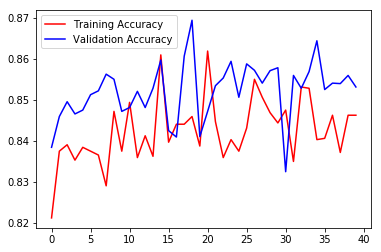

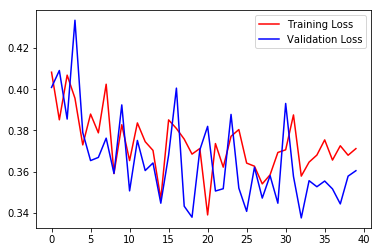

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(epochs,acc, 'r', label='Training Accuracy')
plt.plot(epochs,val_acc, 'b', label='Validation Accuracy')
plt.legend()

plt.figure(2)
plt.plot(epochs,loss, 'r', label='Training Loss')
plt.plot(epochs,val_loss, 'b', label='Validation Loss')
plt.legend()
plt.show